In [56]:
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import nltk
import pandas as pd
import numpy as np
import os
import sys
import pprint
import itertools
import re
from tqdm.notebook import trange, tqdm
from spellchecker import SpellChecker
import html
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec
from transformers import BertModel, BertTokenizer
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers import Flatten,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None

simply_lstm

In [13]:
train_df=pd.read_csv('clean_train.csv')
test_df=pd.read_csv('clean_test.csv')

In [14]:
train_df.head()

,Unnamed: 0,id,keyword,location,text,target
0,0,1,NaN,NaN,"['our', 'deeds', 'are', 'the', 'reason', 'of',...",1
1,1,4,NaN,NaN,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1
2,2,5,NaN,NaN,"['all', 'residents', 'asked', 'to', 'shelter',...",1
3,3,6,NaN,NaN,"['people', 'receive', 'wildfires', 'evacuation...",1
4,4,7,NaN,NaN,"['just', 'got', 'sent', 'this', 'photo', 'from...",1


In [15]:
train_df.columns

Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [59]:
target_train = train_df['target']
tweets_train = train_df['text']
tweets_test = test_df['text']

In [60]:
tweets_train = [eval(text) for text in tweets_train]
tweets_test = [eval(text) for text in tweets_test]

In [61]:
tweets_all = tweets_train+tweets_test

In [63]:
len(tweets_all)

10876

In [64]:
tokenizer = Tokenizer(num_words = 14000)
tokenizer.fit_on_texts(tweets_train)
text_sequences = tokenizer.texts_to_sequences(tweets_train)
test_sequences = tokenizer.texts_to_sequences(tweets_test)
tokens = pad_sequences(text_sequences,maxlen=50)
tokens_test = pad_sequences(test_sequences,maxlen=50)
x_train,x_test,y_train,y_test = train_test_split(
    tokens,target_train,test_size=0.25,random_state=6)

In [84]:
tokens

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  112, 4337,   22,    1,  833,    3,   19,
        244,  132, 1558, 4338,   83,   38], dtype=int32)

In [66]:
x_train.shape,y_train.shape

((5709, 50), (5709,))

In [67]:
simply_model_lstm = Sequential()
simply_model_lstm.add(Embedding(14000,64))
simply_model_lstm.add(LSTM(64,input_shape = (33,1)))
simply_model_lstm.add(Dropout(0.25))
simply_model_lstm.add(Dense(1, activation = 'sigmoid'))
simply_model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          896000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 929,089
Trainable params: 929,089
Non-trainable params: 0
_________________________________________________________________


In [68]:
simply_model_lstm.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [85]:
lstm_history = simply_model_lstm.fit(
    x_train,y_train,
    epochs = 3,
    validation_data = (x_test, y_test), 
    batch_size = 32,
    verbose=1)

Train on 5709 samples, validate on 1904 samples
Epoch 1/3
5709/5709 [==============================] - 24s 4ms/step - loss: 0.2236 - accuracy: 0.9142 - val_loss: 0.5301 - val_accuracy: 0.7794
Epoch 2/3
5709/5709 [==============================] - 23s 4ms/step - loss: 0.2023 - accuracy: 0.9273 - val_loss: 0.5833 - val_accuracy: 0.7742
Epoch 3/3
5709/5709 [==============================] - 23s 4ms/step - loss: 0.1845 - accuracy: 0.9338 - val_loss: 0.5804 - val_accuracy: 0.7831


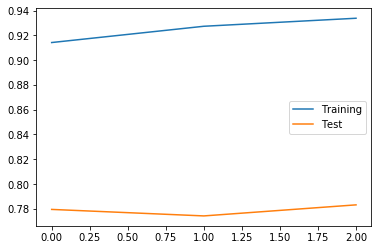

In [86]:
plt.plot(lstm_history.history["accuracy"], label="Training")
plt.plot(lstm_history.history["val_accuracy"], label="Test")
plt.legend()
plt.show()

In [87]:
pred = simply_model_lstm.predict(tokens_test)

In [88]:
submission_df = pd.read_csv('nlp-getting-started/sample_submission.csv')

In [89]:
submission_df['target'] = (np.array(pred) > 0.5).astype('int')
submission_df.target.value_counts()

0    2018
1    1245
Name: target, dtype: int64

In [90]:
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [91]:
submission_df.to_csv('sub.csv', index=False)